# Integrating Embeddings with Queries in an Information Retrieval System

## Objective

In this exercise, we will learn how to integrate embeddings with a query to enhance an Information Retrieval (IR) system. We will use both static and contextual embeddings to generate representations of queries and documents, compute their similarities, and rank the documents based on relevance to the query.

---

## Stages Covered

1. **Introduction to Pre-trained Transformer Models**
   - Load and use BERT for contextual embeddings.
   - Load and use Word2Vec for static embeddings.

2. **Generating Text Embeddings**
   - Generate embeddings for queries and documents using BERT.
   - Generate embeddings for queries and documents using Word2Vec.

3. **Computing Similarity Between Embeddings**
   - Compute cosine similarity between query and document embeddings.
   - Rank documents based on similarity scores.

4. **Integrating Embeddings with Queries**
   - Practical implementation of embedding-based retrieval for a given text corpus.

---

## Prerequisites

- TensorFlow
- Hugging Face's Transformers library
- Gensim library
- Scikit-learn library
- A text corpus in the `../data` folder

---

## Exercise

Follow the steps below to integrate embeddings with a query and enhance your IR system.



Step 0: Verify requirements:

* tensorflow
* transformers
* scikit-learn
* matplotlib
* seaborn

Step 1: Download dataset from Kaggle

URL: https://www.kaggle.com/datasets/zynicide/wine-reviews

In [22]:
%pip install gensim
%pip install transformers
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd

wine_df = pd.read_csv('winemag-data_first150k.csv')
print(wine_df.head())
corpus = wine_df['description']

   Unnamed: 0 country                                        description  \
0           0      US  This tremendous 100% varietal wine hails from ...   
1           1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2           2      US  Mac Watson honors the memory of a wine once ma...   
3           3      US  This spent 20 months in 30% new French oak, an...   
4           4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65.0          Oregon   
4                            La Brûlade      95   66.0        Provence   

            region_1           region_2             variety  \
0        Napa Valley               

Step 2: Load a Pre-trained Transformer Model

Use the BERT model for generating contextual embeddings and Word2Vec for static embeddings.

In [24]:
import tensorflow as tf
import gensim.downloader as api
from transformers import BertTokenizer, TFBertModel

# Load pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Step 3: Generate Text Embeddings

Static Embeddings with Word2Vec

In [25]:
import numpy as np


def generate_word2vec_embeddings(texts):
    embeddings = []
    for text in texts:
        tokens = text.lower().split()
        word_vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(word2vec_model.vector_size))
    return np.array(embeddings)


word2vec_embeddings = generate_word2vec_embeddings(corpus)
print("Word2Vec Embeddings:", word2vec_embeddings)
print("Word2Vec Shape:", word2vec_embeddings.shape)

Word2Vec Embeddings: [[ 0.01978664  0.03414721 -0.00884628 ... -0.01573336  0.06626587
  -0.02784729]
 [ 0.0016861  -0.00124741 -0.00065494 ... -0.04453754  0.06408358
   0.03221512]
 [-0.01758194  0.06408924  0.02408564 ... -0.04092503  0.09110224
   0.01769352]
 ...
 [ 0.02409261  0.03888226  0.06215142 ... -0.00537516  0.06789415
  -0.0012207 ]
 [ 0.01009696  0.04878807 -0.0010405  ... -0.04659453  0.10975574
  -0.01264881]
 [-0.0126537   0.03070068  0.0444759  ... -0.00960471  0.01097419
   0.06093528]]
Word2Vec Shape: (150930, 300)


Contextual Embeddings with BERT

In [26]:
def generate_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :])  # Use [CLS] token representation
    return np.array(embeddings).transpose(0, 2, 1)


bert_embeddings = generate_bert_embeddings(corpus[:10])
print("BERT Embeddings:", bert_embeddings)
print("Word2Vec Shape:", bert_embeddings.shape)

BERT Embeddings: [[[ 0.11967489]
  [-0.48856735]
  [ 0.3645301 ]
  ...
  [-0.43680516]
  [ 0.1197608 ]
  [ 0.18947844]]

 [[-0.05186677]
  [-0.36506552]
  [ 0.64745986]
  ...
  [-0.31474513]
  [ 0.05560053]
  [ 0.5154335 ]]

 [[-0.7317317 ]
  [ 0.3508853 ]
  [-0.01913854]
  ...
  [-0.03388382]
  [ 0.22656593]
  [ 0.30798098]]

 ...

 [[-0.35893524]
  [-0.5862951 ]
  [ 0.41342103]
  ...
  [-0.16299404]
  [ 0.33213353]
  [ 0.49520764]]

 [[-0.06120773]
  [-0.3186196 ]
  [ 0.66368014]
  ...
  [-0.26011413]
  [ 0.22982565]
  [ 0.49291262]]

 [[-0.7911081 ]
  [-0.3179433 ]
  [ 0.24998935]
  ...
  [-0.42931485]
  [ 0.30838823]
  [-0.06678645]]]
Word2Vec Shape: (10, 768, 1)


Step 4: Compute Similarity Between Embeddings

Use the scikit-learn library.

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity between Word2Vec embeddings
word2vec_similarity = cosine_similarity(word2vec_embeddings[:10])
print("Word2Vec Cosine Similarity:\n", word2vec_similarity)

# Cosine similarity between BERT embeddings
bert_similarity = cosine_similarity(bert_embeddings.reshape(10, 768))
print("BERT Cosine Similarity:\n", bert_similarity)

Word2Vec Cosine Similarity:
 [[1.         0.8253629  0.80511198 0.84191353 0.83916097 0.83854598
  0.82169205 0.82485221 0.84638968 0.81403267]
 [0.8253629  1.         0.79154417 0.87045668 0.70443007 0.89196218
  0.85559996 0.90900554 0.82102562 0.81991442]
 [0.80511198 0.79154417 1.         0.78133118 0.76637057 0.81088425
  0.76002815 0.78692912 0.78062805 0.82849419]
 [0.84191353 0.87045668 0.78133118 1.         0.73889366 0.87697816
  0.86926656 0.86583898 0.82994799 0.81447784]
 [0.83916097 0.70443007 0.76637057 0.73889366 1.         0.74084036
  0.72642772 0.75438003 0.84104805 0.73225092]
 [0.83854598 0.89196218 0.81088425 0.87697816 0.74084036 1.
  0.86410356 0.90941287 0.8474781  0.82548948]
 [0.82169205 0.85559996 0.76002815 0.86926656 0.72642772 0.86410356
  1.         0.87098882 0.81831654 0.78823973]
 [0.82485221 0.90900554 0.78692912 0.86583898 0.75438003 0.90941287
  0.87098882 1.         0.86063902 0.83889079]
 [0.84638968 0.82102562 0.78062805 0.82994799 0.84104805 0.

Step 5: Compare Contextual and Static Embeddings

Analyze and compare the similarity results from both BERT and Word2Vec embeddings.

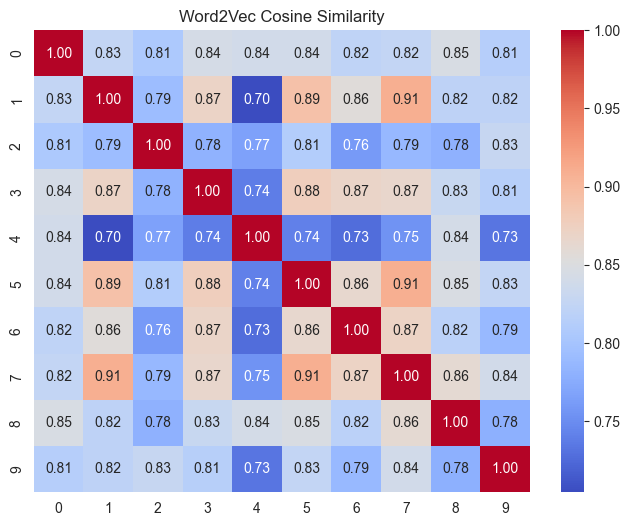

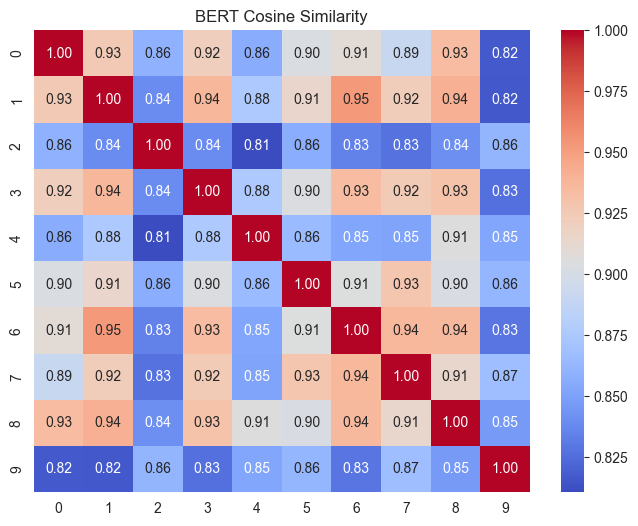

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_similarity_matrix(matrix, title, figsize=(8, 6), annotation=True):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, annot=annotation, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()


plot_similarity_matrix(word2vec_similarity, "Word2Vec Cosine Similarity")
plot_similarity_matrix(bert_similarity, "BERT Cosine Similarity")

Step 6: Applying to Corpus

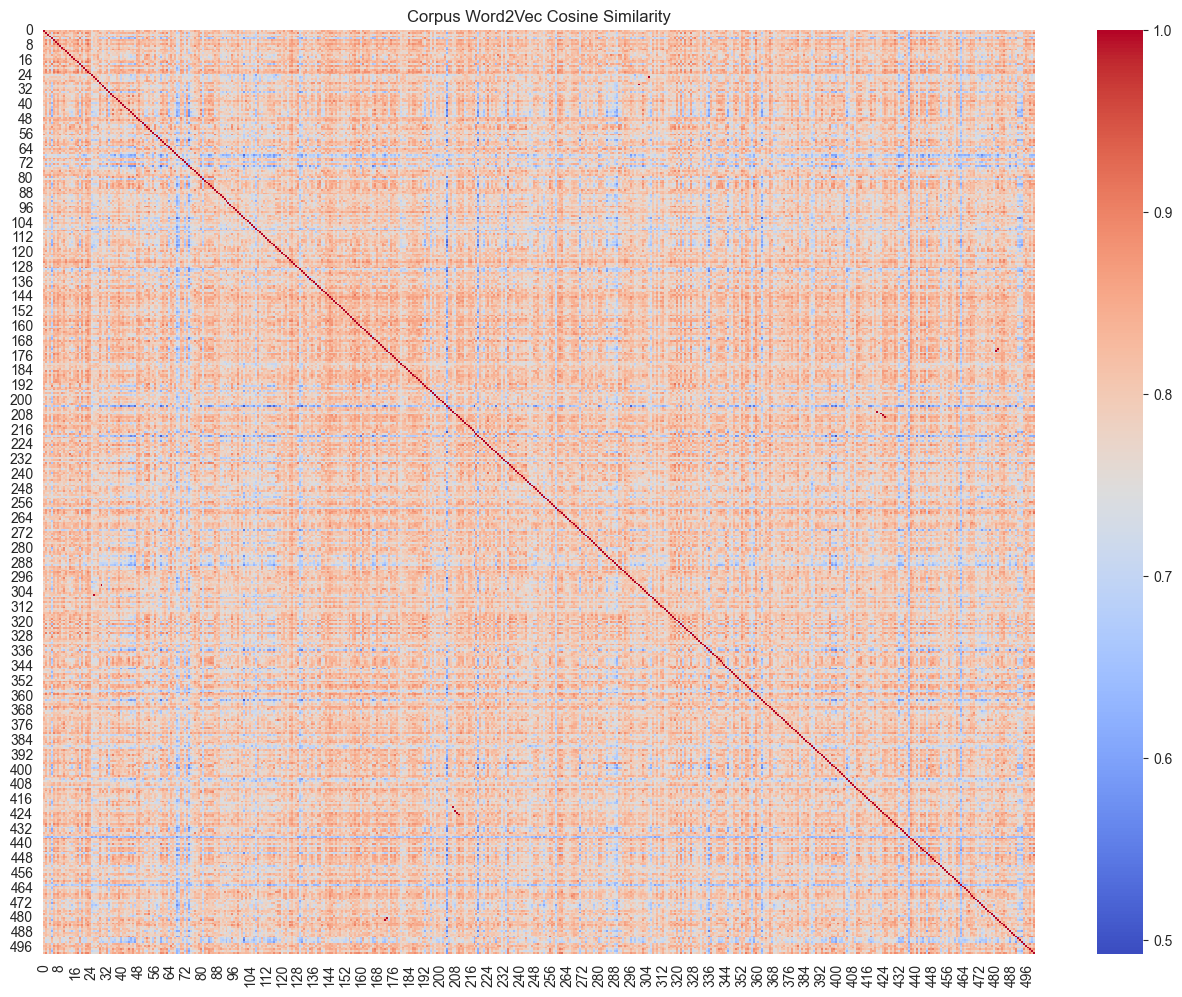

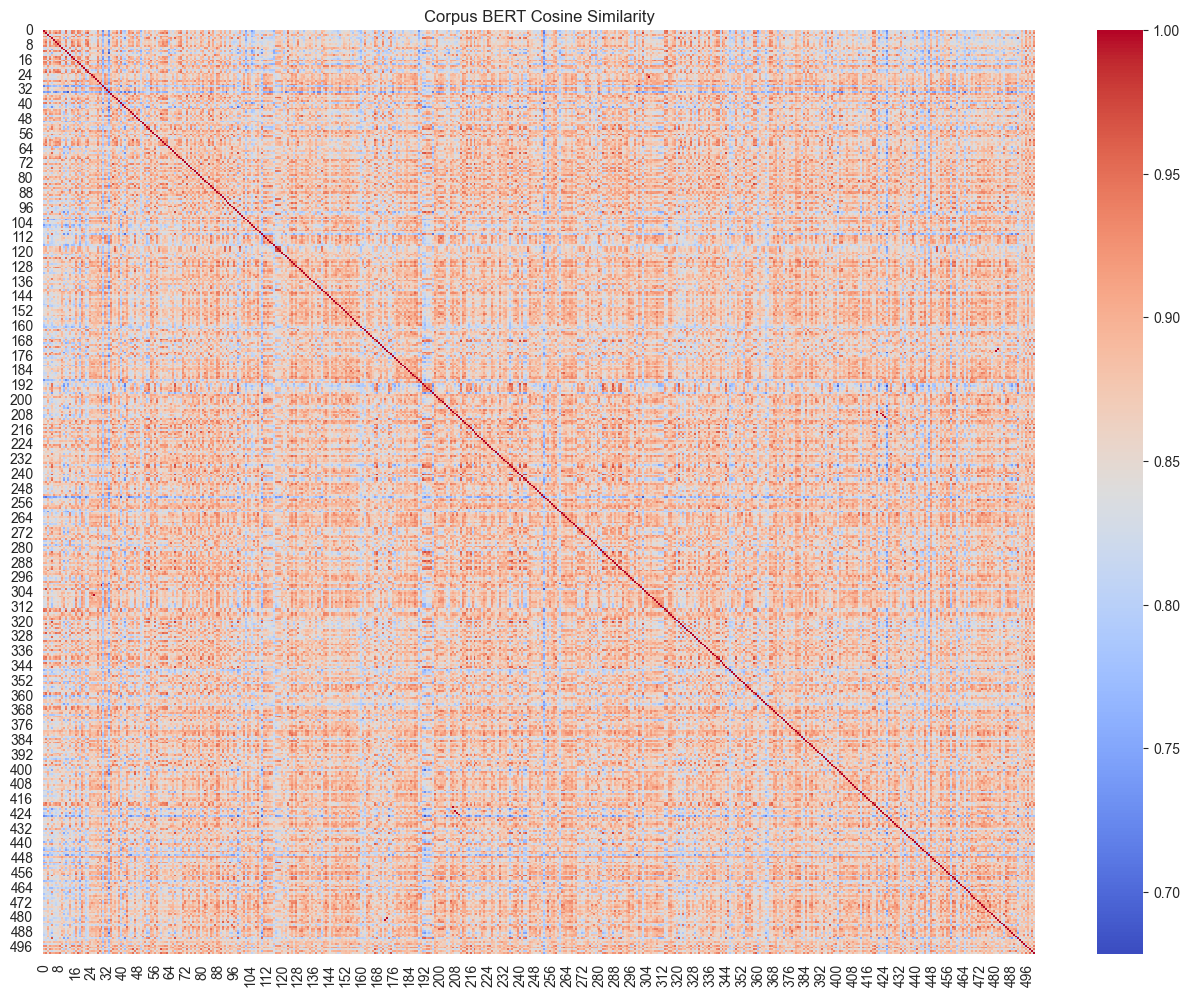

In [29]:
# Generate embeddings for the corpus
corpus_word2vec_embeddings = generate_word2vec_embeddings(corpus[:500])
corpus_bert_embeddings = generate_bert_embeddings(corpus[:500])

# Compute similarity for the corpus
corpus_word2vec_similarity = cosine_similarity(corpus_word2vec_embeddings)
corpus_bert_similarity = cosine_similarity(corpus_bert_embeddings.reshape(corpus_bert_embeddings.shape[:2]))

# Plot similarity matrices
plot_similarity_matrix(corpus_word2vec_similarity, "Corpus Word2Vec Cosine Similarity", figsize=(16, 12),
                       annotation=False)
plot_similarity_matrix(corpus_bert_similarity, "Corpus BERT Cosine Similarity", figsize=(16, 12), annotation=False)

Summary

So far, in this exercise, you learned how to:

* Load a pre-trained transformer model (BERT) and a static embedding model (Word2Vec).
* Generate text embeddings using these models.
* Compute cosine similarity between embeddings.
* Compare the similarity results from both contextual and static embeddings.

Now you have a practical understanding of how transformers and embeddings can be used in Information Retrieval systems.

Let's integrate query search.

### Ejercicio

Antes de trabajar sobre la query, cargamos el archivo embeddings.npy que contiene un array de tipo numpy con

todos los embeddings del corpus.

Este archivo fue generado por el script embeddings.py

In [30]:
bert_embeddings_np = np.load('embeddings.npy')
print("Embeddings:", bert_embeddings_np)
print("Embeddings Shape:", bert_embeddings_np.shape)

Embeddings: [[[ 0.1196747 ]
  [-0.48856777]
  [ 0.36453032]
  ...
  [-0.4368053 ]
  [ 0.11976158]
  [ 0.18947797]]

 [[-0.05186699]
  [-0.36506552]
  [ 0.64746   ]
  ...
  [-0.31474563]
  [ 0.05560102]
  [ 0.5154332 ]]

 [[-0.73173195]
  [ 0.3508852 ]
  [-0.01913834]
  ...
  [-0.03388371]
  [ 0.22656585]
  [ 0.30798078]]

 ...

 [[-0.47793046]
  [-0.3831097 ]
  [-0.12426241]
  ...
  [-0.42497826]
  [ 0.17159437]
  [ 0.52000856]]

 [[-0.5511792 ]
  [-0.35631135]
  [-0.1926566 ]
  ...
  [ 0.09427099]
  [ 0.54605997]
  [ 0.37293747]]

 [[-0.08814185]
  [-0.11376236]
  [ 0.26081333]
  ...
  [-0.1638767 ]
  [ 0.21335356]
  [ 0.35007656]]]
Embeddings Shape: (150930, 768, 1)


Step 7: Generate Embeddings for the Query

Generate embeddings for the query using the same model used for the documents.

Incluimos un input para que el usuario pueda ingresar una query y la guardamos como un array

In [31]:
query = []
query.append(input("Ingresa una query: "))
query

['apple']

Transformamos la query en un vector utilizando Word2Vec

In [32]:
word2vec_query = generate_word2vec_embeddings(query)
print("Word2Vec Embeddings Query:", word2vec_query)
print("Word2Vec Shape Query:", word2vec_query.shape)

Word2Vec Embeddings Query: [[-0.06445312 -0.16015625 -0.01208496  0.13476562 -0.22949219  0.16210938
   0.3046875  -0.1796875  -0.12109375  0.25390625 -0.01428223 -0.06396484
  -0.08056641 -0.05688477 -0.19628906  0.2890625  -0.05151367  0.14257812
  -0.10498047 -0.04736328 -0.34765625  0.35742188  0.265625    0.00188446
  -0.01586914  0.00195312 -0.35546875  0.22167969  0.05761719  0.15917969
   0.08691406 -0.0267334  -0.04785156  0.23925781 -0.05981445  0.0378418
   0.17382812 -0.41796875  0.2890625   0.32617188  0.02429199 -0.01647949
  -0.06494141 -0.08886719  0.07666016 -0.15136719  0.05249023 -0.04199219
  -0.05419922  0.00108337 -0.20117188  0.12304688  0.09228516  0.10449219
  -0.00408936 -0.04199219  0.01409912 -0.02111816 -0.13476562 -0.24316406
   0.16015625 -0.06689453 -0.08984375 -0.07177734 -0.00595093 -0.00482178
  -0.00089264 -0.30664062 -0.0625      0.07958984 -0.00909424 -0.04492188
   0.09960938 -0.33398438 -0.3984375   0.05541992 -0.06689453 -0.04467773
   0.1176757

Igualmente transformamos la query en un vector pero ahora utlizando bert

In [33]:
bert_query = generate_bert_embeddings(query)
print("BERT Embeddings Query:", bert_query)
print("BERT Query Shape:", bert_query.shape)

BERT Embeddings Query: [[[-2.06917167e-01]
  [ 8.80970657e-02]
  [-1.98491424e-01]
  [-5.44866174e-02]
  [-8.45980719e-02]
  [ 3.39002535e-02]
  [ 2.41526052e-01]
  [ 4.70745593e-01]
  [-1.10867634e-01]
  [-7.92226195e-02]
  [-1.31477624e-01]
  [-1.47048756e-02]
  [ 6.09886386e-02]
  [ 2.50711411e-01]
  [ 2.97971442e-02]
  [-1.43340468e-01]
  [-1.52538612e-01]
  [ 3.49762201e-01]
  [ 2.66769260e-01]
  [-1.82771549e-01]
  [-2.37220172e-02]
  [-1.37477428e-01]
  [-2.07272708e-01]
  [-4.53962348e-02]
  [ 1.56401858e-01]
  [-1.70846641e-01]
  [-2.61001587e-02]
  [-1.33434132e-01]
  [ 2.59499401e-01]
  [ 2.09541053e-01]
  [ 2.81961039e-02]
  [ 1.42555907e-01]
  [-1.16075762e-03]
  [ 5.61703257e-02]
  [ 4.13300246e-02]
  [-2.55167335e-02]
  [-7.95595907e-03]
  [-9.66270864e-02]
  [-3.73579003e-02]
  [ 3.77052091e-03]
  [ 1.02670237e-01]
  [-9.60072875e-02]
  [ 2.05937311e-01]
  [-1.41437083e-01]
  [ 5.92778027e-02]
  [-1.94906130e-01]
  [-1.67167735e+00]
  [ 1.05982311e-02]
  [-1.55207574e-0

Step 8: Compute Similarity Between Query and Documents

Compute the similarity between the query embedding and each document embedding.

Calculamos la similaridad utilizando la función cosine_similarity primero para word2vec

In [34]:
word2vec_similarity = cosine_similarity(word2vec_embeddings, word2vec_query)
print("Word2Vec Similarity:\n", word2vec_similarity)

Word2Vec Similarity:
 [[0.36367477]
 [0.43254131]
 [0.45102994]
 ...
 [0.38915827]
 [0.42382121]
 [0.37517416]]


Ahora hacemos lo mismo para BERT pero debemos hacer un reshape primero para el array de embeddings y para la query

In [35]:
bert_reshape = bert_embeddings_np.reshape(150930, 768)
bert_query_reshape = bert_query.reshape(1, 768)

In [36]:
bert_similarity = cosine_similarity(bert_reshape, bert_query_reshape)
print("BERT Similarity Query:\n", bert_similarity)

BERT Similarity Query:
 [[0.71075296]
 [0.70410347]
 [0.76005375]
 ...
 [0.68611205]
 [0.6372542 ]
 [0.74093735]]


Step 9: Retrieve and Rank Documents Based on Similarity Scores

Retrieve and rank the documents based on their similarity scores to the query.

#### Ranking Word2Vec

Primero debemos almacenar los índices de los documentos junto a su similitud para poder identificar los documentos en el ranking

In [37]:
word2vec_query_with_index = []
for index, similarity in enumerate(word2vec_similarity):
    word2vec_query_with_index.append((index, similarity[0]))
word2vec_query_with_index.sort(key=lambda x: x[1], reverse=True)
word2vec_query_with_index

[(3142, 0.7237654144007015),
 (11542, 0.708521224098708),
 (19057, 0.7049866099766489),
 (82537, 0.7049866099766489),
 (6504, 0.7048396064309135),
 (28108, 0.7048396064309135),
 (9420, 0.687413962693366),
 (11208, 0.6832646079032924),
 (32360, 0.6799782118822328),
 (7868, 0.6745191541178359),
 (89305, 0.6715847867588716),
 (8658, 0.6704936373991205),
 (44504, 0.6666477944895525),
 (26104, 0.6664031768089308),
 (51004, 0.6664031768089308),
 (82594, 0.6664031768089308),
 (128914, 0.6664031768089308),
 (56240, 0.6629105436754279),
 (46474, 0.6628603617887765),
 (90547, 0.6627968134423835),
 (45407, 0.6627529346108085),
 (149540, 0.6619566091523765),
 (3727, 0.6614364771100738),
 (98646, 0.6587335384473044),
 (122766, 0.6587335384473044),
 (26441, 0.6581972211763043),
 (88757, 0.6569720754379035),
 (37235, 0.6544540207293976),
 (89435, 0.6544540207293976),
 (9450, 0.6531603343575599),
 (35880, 0.6531603343575599),
 (9839, 0.6526918959201289),
 (28049, 0.6526918959201289),
 (13458, 0.651361

Con los índices almacenados podemos mostrar los 10 documentos más relevantes según Word2Vec

In [38]:
print('Los 10 documentos mas relevantes con Word2Vec:')
for i in range(10):
    print('Documento: ', word2vec_query_with_index[i][0])
    print(corpus[word2vec_query_with_index[i][0]])

Los 10 documentos mas relevantes con Word2Vec:
Documento:  3142
This 100% Ribolla Gialla has aromas of green apple and apple cider. There's nice minerality in the mouth with flavors of apple pie, apple cider and a touch of creaminess. The finish is pleasantly bright.
Documento:  11542
El Jabali—the home vineyard of vintners Richard and Thekla Sanford—delivers a Chardonnay loaded with fresh lemongrass, nectarine and Gravenstein apple scents. There is a pithy grip to the palate, where apple and Anjou pear flavors converge with lime and grapefruit tartness.
Documento:  19057
A simple Chardonnay, with pineapple, apple and mango fruit juice flavors, brightened with zesty acidity.
Documento:  82537
A simple Chardonnay, with pineapple, apple and mango fruit juice flavors, brightened with zesty acidity.
Documento:  6504
Aromas of marmalade, squeezed lime, red apple and apple blossoms hit the nose on this bottling from the Morgan Hill area producer. Ripe with Gala apple and pear flesh, the pala

#### Ranking BERT

Para BERT igualmente debemos almacenar el índice de los documentos para poder identificarlos

In [39]:
bert_query_with_index = []
for index, similarity in enumerate(bert_similarity):
    bert_query_with_index.append((index, similarity[0]))
bert_query_with_index.sort(key=lambda x: x[1], reverse=True)
bert_query_with_index

[(34627, 0.9056574),
 (62639, 0.8862213),
 (117179, 0.8862213),
 (42380, 0.8819244),
 (94520, 0.8819244),
 (119480, 0.8819244),
 (54338, 0.8816828),
 (106478, 0.8816828),
 (131378, 0.8816828),
 (61371, 0.8810636),
 (104541, 0.8810636),
 (127521, 0.8810636),
 (119297, 0.8803097),
 (54531, 0.878387),
 (75171, 0.878387),
 (78727, 0.8778774),
 (26748, 0.8765106),
 (85251, 0.8759316),
 (54055, 0.87500894),
 (106195, 0.87500894),
 (131035, 0.87500894),
 (66597, 0.87498647),
 (113157, 0.87498647),
 (136077, 0.87498647),
 (44775, 0.87480646),
 (96915, 0.87480646),
 (121815, 0.87480646),
 (36022, 0.8736499),
 (103582, 0.8736499),
 (16887, 0.87316996),
 (20990, 0.8700268),
 (51391, 0.8690523),
 (101182, 0.86746603),
 (36700, 0.8669825),
 (91750, 0.8669825),
 (107310, 0.86690855),
 (123480, 0.86690855),
 (84821, 0.866558),
 (65835, 0.86544967),
 (108525, 0.86544967),
 (130905, 0.86544967),
 (144862, 0.86505246),
 (47069, 0.86485845),
 (90119, 0.86485845),
 (108554, 0.86459833),
 (11300, 0.8645208

Ahora mostramos los 10 documentos más relevantes según BERT

In [40]:
print('Los 10 documentos mas relevantes con BERT:')
for i in range(10):
    print('Documento: ', bert_query_with_index[i][0])
    print(corpus[bert_query_with_index[i][0]])

Los 10 documentos mas relevantes con BERT:
Documento:  34627
Too sweet, with so much sugar it might as well be for dessert.
Documento:  62639
Way too sweet for my palate, as if a perfectly good Syrah had a tablespoon of white sugar added.
Documento:  117179
Way too sweet for my palate, as if a perfectly good Syrah had a tablespoon of white sugar added.
Documento:  42380
Too sweet in sugary blackberry jam to earn a higher score, but if that's your liking, go for it.
Documento:  94520
Too sweet in sugary blackberry jam to earn a higher score, but if that's your liking, go for it.
Documento:  119480
Too sweet in sugary blackberry jam to earn a higher score, but if that's your liking, go for it.
Documento:  54338
Just barely drinkable, with sweet and sour raspberry fruit sauce flavors.
Documento:  106478
Just barely drinkable, with sweet and sour raspberry fruit sauce flavors.
Documento:  131378
Just barely drinkable, with sweet and sour raspberry fruit sauce flavors.
Documento:  61371
A g